In [1]:
import os

In [3]:
wav_path = '/Users/ginoprasad/autotune/m4a_files/New Recording.m4a'

In [4]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.0.0.dev20221214
0.14.0.dev20221214


In [6]:
from IPython.display import Audio

In [9]:
wav, sample_rate = torchaudio.load(wav_path)
wav = wav[0]
wav = wav[200000:250000]
Audio(wav, rate=sample_rate)

In [13]:
downsampling_const = 1

In [15]:
downsampled_wav = wav[::downsampling_const]

In [16]:
downsampled_wav

tensor([-0.0009,  0.0018,  0.0026,  ..., -0.0188, -0.0132, -0.0092])

In [17]:
len(wav), len(downsampled_wav)

(50000, 50000)

In [18]:
import matplotlib.pyplot as plt

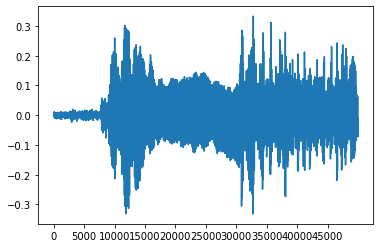

In [20]:
plt.plot(range(len(downsampled_wav)), downsampled_wav)
plt.xticks(range(0, len(downsampled_wav), 5000))
None

# Do a fast fourier transform of bruyeres data, for size k for $(1/32) (\text{sample_rate})$

= $(1/32) (\text{sample_rate})$ = $(32000/32) = 1000 ~= 1024$

In [21]:
sample_rate

48000

In [23]:
len(wav)

50000

In [24]:
len(wav) / sample_rate

1.0416666666666667

In [25]:
k = 8192

In [26]:
import numpy as np

In [27]:
def fft(f, exponent_sign=-1):
    f = f.astype(np.float64)
    zero = np.zeros_like(f)[:1]
    if len(f) == 1:
        return f, zero
    assert not len(f) & 1
    
    evens = f[::2]
    odds = f[1::2]
    
    fft_sum_cos, fft_sum_sin = fft(evens, exponent_sign=exponent_sign)
    fft_odds_cos, fft_odds_sin = fft(odds, exponent_sign=exponent_sign)
        
        
    series_domain = np.array([(exponent_sign * 2 * np.pi * n) / len(f) for n in range(len(f) // 2)])
    cos_series = np.cos(series_domain)
    sin_series = np.sin(series_domain)
    
    fft_sum_cos += (cos_series * fft_odds_cos) - (sin_series * fft_odds_sin) 
    fft_sum_sin += (cos_series * fft_odds_sin) + (sin_series * fft_odds_cos) 
    
    diff = np.array([(evens - odds).sum()])    
    fft_sum_cos = np.concatenate((fft_sum_cos, diff, fft_sum_cos[:0:-1]))
    fft_sum_sin = np.concatenate((fft_sum_sin, zero, -fft_sum_sin[:0:-1]))
    
    return fft_sum_cos, fft_sum_sin

In [28]:
def get_amplitude_spectrum(f_hat_cos, f_hat_sin):
    return np.concatenate(([0], sample_rate * np.arange(1, len(f_hat_cos)) / len(f_hat_cos))), np.linalg.norm(np.stack((f_hat_cos, f_hat_sin), axis=1), axis=1)

In [29]:
def predict_freqs_old(f, threshold=0.001, decimals=1, min_amplitude_threshold=0.01):
    fft_cos, fft_sin = fft(f)
    frequencies, amplitude_spectrum = get_amplitude_spectrum(fft_cos, fft_sin)
    
#     print(f"Using Amplitude Threshold {len(f) * threshold}")
    candidates = list(set([frequency for frequency, amp in zip(frequencies, amplitude_spectrum) if frequency < notes[-1][0] and amp > len(f) * min_amplitude_threshold]))
    candidates.sort()
    return candidates

In [30]:
def predict_freqs(f, threshold=0.001, decimals=1, min_amplitude_threshold=0.01):
    fft_cos, fft_sin = fft(f)
    frequencies, amplitude_spectrum = get_amplitude_spectrum(fft_cos, fft_sin)
    
#     print(f"Using Amplitude Threshold {len(f) * threshold}")
    candidates = list(set([frequency for frequency, amp in zip(frequencies, amplitude_spectrum) if frequency < notes[-1][0] and amp > len(f) * min_amplitude_threshold]))
    candidates.sort()
    return candidates

In [31]:
def gaussian_kernel(length, std=1):
    assert length & 1
    
    center = length // 2
    kernel = []
    for i in range(length):
        distance = abs(i - center)
        kernel.append(np.exp(-(distance * distance) / (2 * std * std)))
    kernel = np.array(kernel)
    
    kernel = kernel - (np.sum(kernel) / length)
    kernel = kernel / np.linalg.norm(kernel)
    return kernel

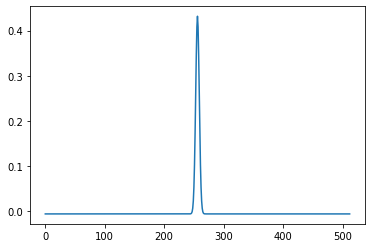

In [32]:
length = (k // 16) + 1
std = 3
plt.plot(range(length), gaussian_kernel(length, std))

In [33]:
gkernel = gaussian_kernel(length, std)

# Assigning Pitches to Frequencies

A3  220.00

A#3/Bb3    233.08

B3  246.94

C4  261.63

C#4/Db4    277.18

D4  293.66

D#4/Eb4    311.13

E4  329.63

F4  349.23

F#4/Gb4    369.99

G4  392.00

G#4/Ab4    415.30

A4  440.00

A#4/Bb4    466.16

In [34]:
prelim_notes_octave = 4
prelim_notes = [("C", 261.63), ("C#", 277.18), ("D", 293.66), ("D#", 311.13),
         ("E", 329.63), ("F", 349.23), ("F#", 369.99), ("G", 392.00), ("G#", 415.30), ("A", 440.00), ("A#", 466.16), ("B", 493.88), ]
prelim_notes

[('C', 261.63),
 ('C#', 277.18),
 ('D', 293.66),
 ('D#', 311.13),
 ('E', 329.63),
 ('F', 349.23),
 ('F#', 369.99),
 ('G', 392.0),
 ('G#', 415.3),
 ('A', 440.0),
 ('A#', 466.16),
 ('B', 493.88)]

In [35]:
import pandas as pd

## Octave Higher = (2) lower octave

In [36]:
notes = [(freq * (2 ** (octave - prelim_notes_octave)), f"{name}{octave}") for octave in range(8) for name, freq in prelim_notes]
pd.DataFrame(notes)

,0,1
0,16.351875,C0
1,17.323750,C#0
2,18.353750,D0
3,19.445625,D#0
4,20.601875,E0
...,...,...
91,3136.000000,G7
92,3322.400000,G#7
93,3520.000000,A7
94,3729.280000,A#7


In [37]:
notes_dict = {name: freq for freq, name in notes}
notes_dict

{'C0': 16.351875,
 'C#0': 17.32375,
 'D0': 18.35375,
 'D#0': 19.445625,
 'E0': 20.601875,
 'F0': 21.826875,
 'F#0': 23.124375,
 'G0': 24.5,
 'G#0': 25.95625,
 'A0': 27.5,
 'A#0': 29.135,
 'B0': 30.8675,
 'C1': 32.70375,
 'C#1': 34.6475,
 'D1': 36.7075,
 'D#1': 38.89125,
 'E1': 41.20375,
 'F1': 43.65375,
 'F#1': 46.24875,
 'G1': 49.0,
 'G#1': 51.9125,
 'A1': 55.0,
 'A#1': 58.27,
 'B1': 61.735,
 'C2': 65.4075,
 'C#2': 69.295,
 'D2': 73.415,
 'D#2': 77.7825,
 'E2': 82.4075,
 'F2': 87.3075,
 'F#2': 92.4975,
 'G2': 98.0,
 'G#2': 103.825,
 'A2': 110.0,
 'A#2': 116.54,
 'B2': 123.47,
 'C3': 130.815,
 'C#3': 138.59,
 'D3': 146.83,
 'D#3': 155.565,
 'E3': 164.815,
 'F3': 174.615,
 'F#3': 184.995,
 'G3': 196.0,
 'G#3': 207.65,
 'A3': 220.0,
 'A#3': 233.08,
 'B3': 246.94,
 'C4': 261.63,
 'C#4': 277.18,
 'D4': 293.66,
 'D#4': 311.13,
 'E4': 329.63,
 'F4': 349.23,
 'F#4': 369.99,
 'G4': 392.0,
 'G#4': 415.3,
 'A4': 440.0,
 'A#4': 466.16,
 'B4': 493.88,
 'C5': 523.26,
 'C#5': 554.36,
 'D5': 587.32,


# Since computation is high, need steps for k-mers to reduce time

In [38]:
step = 100

In [42]:
k

8192

In [43]:
len(first_10)

50000

In [44]:
def get_kmers(wav):
    return (wav[i:i+k] for i in range(0, len(wav), step) if i+k <= len(wav))

In [45]:
total_freqs = []
for i, kmer in enumerate(get_kmers(first_10)):
    kmer = kmer.numpy()
    freqs = predict_freqs(kmer)
    print(f"Start: second {i * step / sample_rate}", freqs)
    total_freqs.append(freqs)
#     break

Start: second 0.0 []
Start: second 0.0020833333333333333 []
Start: second 0.004166666666666667 []
Start: second 0.00625 []
Start: second 0.008333333333333333 []
Start: second 0.010416666666666666 []
Start: second 0.0125 []
Start: second 0.014583333333333334 []
Start: second 0.016666666666666666 []
Start: second 0.01875 []
Start: second 0.020833333333333332 []
Start: second 0.022916666666666665 []
Start: second 0.025 []
Start: second 0.027083333333333334 []
Start: second 0.029166666666666667 []
Start: second 0.03125 []
Start: second 0.03333333333333333 []
Start: second 0.035416666666666666 []
Start: second 0.0375 []
Start: second 0.03958333333333333 []
Start: second 0.041666666666666664 []
Start: second 0.04375 []
Start: second 0.04583333333333333 []
Start: second 0.04791666666666667 []
Start: second 0.05 []
Start: second 0.052083333333333336 []
Start: second 0.05416666666666667 []
Start: second 0.05625 []
Start: second 0.058333333333333334 []
Start: second 0.06041666666666667 []
Start:

Start: second 0.175 [333.984375, 339.84375, 345.703125, 667.96875, 679.6875, 691.40625, 955.078125, 960.9375, 972.65625, 978.515625, 984.375, 990.234375, 996.09375, 1001.953125, 1031.25]
Start: second 0.17708333333333334 [333.984375, 339.84375, 345.703125, 667.96875, 679.6875, 691.40625, 955.078125, 960.9375, 972.65625, 978.515625, 984.375, 990.234375, 996.09375, 1001.953125, 1031.25]
Start: second 0.17916666666666667 [333.984375, 339.84375, 345.703125, 667.96875, 679.6875, 691.40625, 955.078125, 960.9375, 972.65625, 978.515625, 984.375, 990.234375, 996.09375, 1001.953125, 1031.25]
Start: second 0.18125 [333.984375, 339.84375, 345.703125, 667.96875, 679.6875, 691.40625, 955.078125, 960.9375, 972.65625, 978.515625, 984.375, 990.234375, 996.09375, 1001.953125, 1031.25]
Start: second 0.18333333333333332 [333.984375, 339.84375, 345.703125, 667.96875, 679.6875, 691.40625, 955.078125, 960.9375, 972.65625, 978.515625, 984.375, 990.234375, 996.09375, 1001.953125, 1031.25]
Start: second 0.18541

Start: second 0.275 [333.984375, 339.84375, 345.703125, 351.5625, 691.40625]
Start: second 0.27708333333333335 [339.84375, 345.703125, 351.5625, 691.40625, 697.265625]
Start: second 0.2791666666666667 [339.84375, 345.703125, 351.5625, 691.40625, 697.265625]
Start: second 0.28125 [339.84375, 345.703125, 351.5625, 691.40625, 697.265625]
Start: second 0.2833333333333333 [339.84375, 345.703125, 351.5625, 691.40625, 697.265625]
Start: second 0.28541666666666665 [339.84375, 345.703125, 351.5625, 691.40625, 697.265625]
Start: second 0.2875 [339.84375, 345.703125, 351.5625, 697.265625]
Start: second 0.28958333333333336 [339.84375, 345.703125, 351.5625]
Start: second 0.2916666666666667 [339.84375, 345.703125, 351.5625]
Start: second 0.29375 [339.84375, 345.703125, 351.5625]
Start: second 0.29583333333333334 [339.84375, 345.703125, 351.5625]
Start: second 0.29791666666666666 [339.84375, 345.703125, 351.5625]
Start: second 0.3 [339.84375, 345.703125, 351.5625]
Start: second 0.3020833333333333 [33

Start: second 0.525 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125]
Start: second 0.5270833333333333 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125]
Start: second 0.5291666666666667 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125]
Start: second 0.53125 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125, 720.703125]
Start: second 0.5333333333333333 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125, 720.703125]
Start: second 0.5354166666666667 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125, 720.703125]
Start: second 0.5375 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125, 720.703125]
Start: second 0.5395833333333333 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578125, 720.703125]
Start: second 0.5416666666666666 [351.5625, 357.421875, 363.28125, 375.0, 380.859375, 386.71875, 392.578

Start: second 0.6583333333333333 [363.28125, 369.140625, 375.0, 386.71875, 392.578125, 410.15625, 416.015625, 427.734375, 433.59375, 937.5, 960.9375]
Start: second 0.6604166666666667 [363.28125, 369.140625, 375.0, 386.71875, 392.578125, 410.15625, 416.015625, 427.734375, 433.59375, 937.5, 960.9375]
Start: second 0.6625 [357.421875, 363.28125, 369.140625, 386.71875, 392.578125, 398.4375, 410.15625, 416.015625, 433.59375, 937.5, 960.9375]
Start: second 0.6645833333333333 [357.421875, 363.28125, 369.140625, 386.71875, 392.578125, 398.4375, 410.15625, 416.015625, 433.59375, 937.5, 960.9375]
Start: second 0.6666666666666666 [357.421875, 363.28125, 369.140625, 386.71875, 392.578125, 398.4375, 404.296875, 410.15625, 416.015625, 433.59375, 937.5, 960.9375]
Start: second 0.66875 [357.421875, 363.28125, 369.140625, 386.71875, 392.578125, 398.4375, 404.296875, 410.15625, 416.015625, 427.734375, 433.59375, 937.5, 960.9375]
Start: second 0.6708333333333333 [357.421875, 363.28125, 369.140625, 386.71

Start: second 0.8145833333333333 [363.28125, 369.140625, 410.15625]
Start: second 0.8166666666666667 [363.28125, 369.140625, 410.15625]
Start: second 0.81875 [363.28125, 369.140625, 410.15625]
Start: second 0.8208333333333333 [363.28125, 369.140625, 410.15625, 925.78125]
Start: second 0.8229166666666666 [363.28125, 369.140625, 410.15625, 925.78125]
Start: second 0.825 [363.28125, 369.140625, 410.15625, 427.734375, 925.78125]
Start: second 0.8270833333333333 [363.28125, 369.140625, 410.15625, 427.734375]
Start: second 0.8291666666666667 [363.28125, 369.140625, 410.15625, 427.734375]
Start: second 0.83125 [363.28125, 369.140625, 410.15625, 427.734375]
Start: second 0.8333333333333334 [363.28125, 369.140625, 410.15625, 427.734375, 445.3125]
Start: second 0.8354166666666667 [363.28125, 369.140625, 410.15625, 427.734375]
Start: second 0.8375 [363.28125, 369.140625, 410.15625, 427.734375]
Start: second 0.8395833333333333 [363.28125, 369.140625, 410.15625, 427.734375]
Start: second 0.84166666

In [46]:
import bisect

In [47]:
test = 440

In [48]:
def closest_notes(freq_list):
    related_notes = []
    for freq in freq_list:
        right = bisect.bisect(notes, (freq, ''))
        if right == len(notes):
            right_val = np.inf
        else:
            right_diff = (abs(notes[right][0] - test), notes[right][1])
        left = right - 1
        left_diff = (abs(notes[left][0] - test), notes[left][1])
        related_notes.append((min(left_diff, right_diff)[1]))
    return list(sorted(set(related_notes), key=lambda x: notes_dict[x]))

In [49]:
closest_notes([440, 550, 660])

['A4', 'C5', 'E5']

In [50]:
k

8192

In [51]:
step

100

In [52]:
k = 2 ** 13
k

8192

In [106]:
step

100

In [53]:
note_list = []
for i, kmer in enumerate(get_kmers(first_10)):
    kmer = kmer.numpy()
    freqs = predict_freqs(kmer)
    
    note_ls = closest_notes(freqs)
    print(f"Start: second {i * step / sample_rate}", note_ls)
    note_list.append(note_ls)
#     break

Start: second 0.0 []
Start: second 0.0020833333333333333 []
Start: second 0.004166666666666667 []
Start: second 0.00625 []
Start: second 0.008333333333333333 []
Start: second 0.010416666666666666 []
Start: second 0.0125 []
Start: second 0.014583333333333334 []
Start: second 0.016666666666666666 []
Start: second 0.01875 []
Start: second 0.020833333333333332 []
Start: second 0.022916666666666665 []
Start: second 0.025 []
Start: second 0.027083333333333334 []
Start: second 0.029166666666666667 []
Start: second 0.03125 []
Start: second 0.03333333333333333 []
Start: second 0.035416666666666666 []
Start: second 0.0375 []
Start: second 0.03958333333333333 []
Start: second 0.041666666666666664 []
Start: second 0.04375 []
Start: second 0.04583333333333333 []
Start: second 0.04791666666666667 []
Start: second 0.05 []
Start: second 0.052083333333333336 []
Start: second 0.05416666666666667 []
Start: second 0.05625 []
Start: second 0.058333333333333334 []
Start: second 0.06041666666666667 []
Start:

Start: second 0.37083333333333335 ['F4', 'F#4']
Start: second 0.3729166666666667 ['F4', 'F#4']
Start: second 0.375 ['F4', 'F#4']
Start: second 0.3770833333333333 ['F4', 'F#4']
Start: second 0.37916666666666665 ['F4', 'F#4']
Start: second 0.38125 ['F4', 'F#4']
Start: second 0.38333333333333336 ['F4', 'F#4']
Start: second 0.3854166666666667 ['F4', 'F#4']
Start: second 0.3875 ['F4', 'F#4']
Start: second 0.38958333333333334 ['F4', 'F#4']
Start: second 0.39166666666666666 ['F4', 'F#4']
Start: second 0.39375 ['F4', 'F#4']
Start: second 0.3958333333333333 ['F4', 'F#4']
Start: second 0.39791666666666664 ['F#4']
Start: second 0.4 ['F#4']
Start: second 0.40208333333333335 ['F#4']
Start: second 0.4041666666666667 ['F#4']
Start: second 0.40625 ['F#4']
Start: second 0.4083333333333333 ['F#4']
Start: second 0.41041666666666665 ['F#4']
Start: second 0.4125 ['F#4']
Start: second 0.41458333333333336 ['F#4']
Start: second 0.4166666666666667 ['F#4']
Start: second 0.41875 ['F#4']
Start: second 0.420833333

Start: second 0.7041666666666667 ['F#4', 'G#4', 'A4']
Start: second 0.70625 ['F#4', 'G#4', 'A4']
Start: second 0.7083333333333334 ['F#4', 'G#4', 'A4']
Start: second 0.7104166666666667 ['F#4', 'G#4', 'A4']
Start: second 0.7125 ['F#4', 'G#4', 'A4']
Start: second 0.7145833333333333 ['F#4', 'G#4', 'A4']
Start: second 0.7166666666666667 ['F#4', 'G#4', 'A4']
Start: second 0.71875 ['F#4', 'G#4', 'A4']
Start: second 0.7208333333333333 ['F#4', 'G#4', 'A4']
Start: second 0.7229166666666667 ['F#4', 'G#4', 'A4']
Start: second 0.725 ['F#4', 'G#4', 'A4']
Start: second 0.7270833333333333 ['F#4', 'G#4', 'A4']
Start: second 0.7291666666666666 ['F#4', 'G#4', 'A4']
Start: second 0.73125 ['F#4', 'G#4', 'A4']
Start: second 0.7333333333333333 ['F#4', 'G#4', 'A4']
Start: second 0.7354166666666667 ['F#4', 'G#4', 'A4', 'A5']
Start: second 0.7375 ['F#4', 'G#4', 'A4', 'A5']
Start: second 0.7395833333333334 ['F#4', 'G#4', 'A4']
Start: second 0.7416666666666667 ['F#4', 'G#4', 'A4']
Start: second 0.74375 ['F#4', 'G

In [54]:
note_list

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['A#5', 'B5'],
 ['E5', 'A#5', 'B5'],
 ['E5', 'A#5', 'B5'],
 ['E5', 'A#5', 'B5'],
 ['E5', 'A#5', 'B5'],
 ['E5', 'A#5', 'B5'],
 ['E5', 'A#5', 'B5'],
 ['E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5', 'A#5', 'B5'],
 ['F4', 'E5',

In [55]:
base = np.arange(0, 2 ** 12).astype(np.float64)

In [56]:
len(base)

4096

0.0020833333333333333

In [57]:
amplitude = 0.5

In [119]:
def get_frequency(frequency):
    c = (frequency * 2 * np.pi) / sample_rate
    wavelet_ = amplitude * np.sin(c * base)
    return wavelet_

In [127]:
Audio(get_frequency(notes_dict['A4']), rate=sample_rate)

In [120]:
len(note_list)

419

In [121]:
sample_rate

48000

In [122]:
len(note_list) / 32

13.09375

In [132]:
step

100

In [133]:
def reconstruct():
    wav = []
    for note_ls in note_list:
        wav.append(np.zeros_like(base))
        for note in note_ls:
            wav[-1] += get_frequency(notes_dict[note])[:step]
    return Audio(np.concatenate(wav), rate=sample_rate)

In [134]:
Audio(wav, rate=sample_rate)

In [135]:
reconstruct()

ValueError: operands could not be broadcast together with shapes (4096,) (100,) (4096,) 

In [97]:
Audio(wav)

ValueError: rate must be specified when data is a numpy array or list of audio samples.